# SNA
## Android malware detector

Authors:

Nguyen Minh Tuan


Le Dinh Nam


Nguyen Thai Hung


This file contains the first two tasks.

## Task 1
<font color='gray'>Use one classifier family with default parameters, train with the training data and evaluate it with the test data (both with the processed features). To evaluate on the test data, I am interested in the confusion matrix, accuracy, precision, recall, and F1 measure. You need to adequately interpret the results obtained with these metrics.</font>

In [ ]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# necessary paths
feature_of_counts = "./data/processed_data/feature_vectors_counts.csv"

# Random Seed for reproducible experiments
RS = 42
np.random.seed(RS)

In [ ]:
# data exploration
dataset = pd.read_csv(feature_of_counts, index_col=0)

# as defined in data_extraction.py
# "feature": s1,
# "permission": s2,
# "activity": s3,
# "service_receiver": s3,
# "provider": s3,
# "service": s3,
# "intent": s4,
# "api_call": s5,
# "real_permission": s6,
# "call": s7,
# "url": s8
display(dataset.head())

,sha256,s1,s2,s3,s4,s5,s6,s7,s8,malware
0,439aa0775930d00bae3db3546eaf309b4f64019524b002...,1,2,15,6,3,2,5,18,False
1,654b4564aea51c03ad1d38401dba63fbaa9329378f3405...,6,5,1,2,3,3,4,9,False
2,83ac70838e9a6e33ec057d90ea1a4f7ad57c90e4e98ee9...,2,0,2,2,2,1,1,4,False
3,1a87d8b10f9969a310b34d7b4b70898ab3e834a820d59b...,1,3,3,2,3,2,4,11,False
4,e4393b74e3299d4a881ce54086a55c9ece37602c390618...,2,0,4,2,1,1,1,0,False


In [ ]:
num_beningware = len(dataset[dataset['malware'] == False])
num_malware = len(dataset[dataset['malware'] == True])

print("Number of Benignware:", num_beningware)
print("Number of Malware:", num_malware)

Number of Benignware: 123453
Number of Malware: 5560


In [ ]:
# Undersampling

benigware_indices = dataset[dataset.malware == False].index
benigware_indices_to_drop = np.random.choice(benigware_indices, num_beningware - num_malware, replace=False)
dataset = dataset.drop(benigware_indices_to_drop)

num_beningware = len(dataset[dataset['malware'] == False])
num_malware = len(dataset[dataset['malware'] == True])

print("Number of Benignware:", num_beningware)
print("Number of Malware:", num_malware)

Number of Benignware: 5560
Number of Malware: 5560


In [ ]:
X = dataset.drop(columns=['sha256', 'malware'])
y = dataset['malware']

display(X.head(5))
display(y.head(5))

,s1,s2,s3,s4,s5,s6,s7,s8
12,1,5,2,2,4,4,6,11
30,6,25,12,4,12,11,8,42
48,2,3,1,2,1,1,2,0
58,2,4,1,2,3,2,4,6
63,6,9,7,2,9,8,11,64


12     True
30     True
48     True
58    False
63    False
Name: malware, dtype: bool

In [ ]:
# split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RS)

# preprocess data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
# train model
clf = LogisticRegression(random_state=RS)
clf.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [ ]:
# predict for test set
predicted = clf.predict(X_test_scaled)

In [ ]:
# evaluation metrics
def print_metrics(y_test, predicted):
	print("acc       {:.4}".format(metrics.accuracy_score(y_test, predicted)))
	print("f1        {:.4}".format(metrics.f1_score(y_test, predicted)))
	print("precision {:.4}".format(metrics.precision_score(y_test, predicted)))
	print("recall    {:.4}".format(metrics.recall_score(y_test, predicted)))


In [ ]:
print_metrics(y_test, predicted)

acc       0.8327
f1        0.8206
precision 0.8596
recall    0.7851


In [ ]:
# confusion matrix
def plot_conf_mat(y_test, predicted):
	conf_mat = metrics.confusion_matrix(y_test, predicted)

	# https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
	# Change figure size and increase dpi for better resolution
	plt.figure(figsize=(8,6), dpi=100)
	# Scale up the size of all text
	sns.set(font_scale = 1.1)

	# Plot Confusion Matrix using Seaborn heatmap()
	# Parameters:
	# first param - confusion matrix in array format
	# annot = True: show the numbers in each heatmap cell
	# fmt = 'd': show numbers as integers.
	ax = sns.heatmap(conf_mat, annot=True, fmt='d', )

	# set x-axis label and ticks.
	ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
	ax.xaxis.set_ticklabels(['Negative', 'Positive'])

	# set y-axis label and ticks
	ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
	ax.yaxis.set_ticklabels(['Negative', 'Positive'])

	# set plot title
	ax.set_title("Confusion Matrix", fontsize=14, pad=20)

	plt.show()

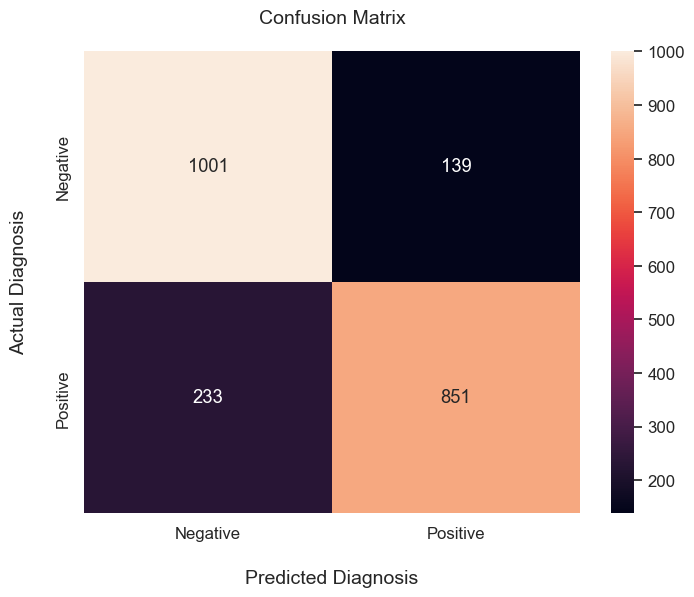

In [ ]:
plot_conf_mat(y_test, predicted)

## Task 2
<font color='gray'>Use several classifiers from different families and with different parameters beyond the default ones. Now, you will do cross-validation with the training data (you can choose the number of folds, e.g., the K), and compare the models. For this, you could simply use average AUC across folds for each model. However, note that the dataset is imbalanced (the number of benign instances is way higher than malicious ones), so you may want to use a balancing technique – for instance, under-sampling the benign class to end up with the same number of benign classes than malicious ones2. With the best resulting model from all those attempted, evaluate it on the test data, again with the confusion matrix, accuracy, precision, recall, and F1 measure. Importantly, you need to explain and justify your choices throughout the task and interpret the results adequately.</font>

Models chosen:
1. DecisionTree,
1. SVC,
1. LogisticRegression,
1. RidgeClassifier,
1. KNeighborsClassifier

In [ ]:
CV_SPLITS = 5
models = {}

To fine-tune hyperparameters of the models, we decided to use GridSearchCV. It allows us to specify a range of values for each hyperparameter, and it will exhaustively search over all possible combinations to determine the set of values that results in the highest model performance. It provides a build in cross-validation mechanism, so we don't have to implement it manually.

In [ ]:
def get_best_estimator(
	estimator: BaseEstimator,
	params_grid: dict,
	X: pd.DataFrame,
	y: pd.Series
):
	clf = GridSearchCV(
		estimator=estimator,
		param_grid=params_grid,
		cv=KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RS),
		n_jobs=5,
		scoring='roc_auc',
		return_train_score=True
	)

	clf.fit(X, y)

	print(f'Hyperparameters found:')
	display(clf.best_params_)
	print(f'Best score: {clf.best_score_:.4}')

	return {'clf': clf.best_estimator_, 'auc': clf.best_score_, 'params': clf.best_params_}

To not re-train the models every time we run the notebook, we decided to save the best models to .pkl files.

In [ ]:
models_path = "./models/"

def try_to_load_model(name: str):
    if os.path.exists(f'{models_path}{name}.pkl'):
        with open(f'{models_path}{name}.pkl', 'rb') as f:
            model_data = pickle.load(f)
            print(f'Loaded {name} model from file')
            print(f'Hyperparameters:')
            display(model_data["params"])
            print(f'Best score: {model_data["auc"]:.4}')
            return model_data
    else:
        print(f'No {name} model found')
        return None

def save_model(name: str, model):
    print(f'Saving {name} model to file')
    with open(f'{models_path}{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

### [Decision Tree](https://scikit-learn.org/stable/modules/tree.html)

Decision trees are a popular choice for binary classification tasks because they are easy to interpret and visualize. They are widely use because they are able to automatically perform feature selection by choosing the most informative features to split on. However, decision trees can be prone to overfitting if they are too complex or the data is noisy. Furthermore, according to the scikit-learn documentation:
> [Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.](https://scikit-learn.org/stable/modules/tree.html#:~:text=Decision%20tree%20learners%20create%20biased%20trees%20if%20some%20classes%20dominate.%20It%20is%20therefore%20recommended%20to%20balance%20the%20dataset%20prior%20to%20fitting%20with%20the%20decision%20tree.)

However, before we decided to use under-sampling throughout the whole coursework, using `class_weight='balanced'` seemed to give sufficient results.

Hyperparameters we decided to tune:
- `criterion`: The function to measure the quality of a split.
  - `gini` (default) - measures the impurity of a split in terms of the probability of misclassifying a randomly chosen element from the set. It is typically faster.
  - `entropy` - measures the impurity of a split in terms of the amount of information required to identify the class label of a randomly chosen element from the set. It may be more effective for problems with large numbers of classes.
- `max_depth`: The maximum depth of the tree.
  - `None` (default) - nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples. It controls the size and complexity of the tree and can help prevent overfitting.
  - *integers* `{4, 8, 12, 16, 20}`
- `max_features`: The number of features to consider when looking for the best split. Because the number of features is relatively small, we didn't think there was a need for limmiting the number of features, but we decided to test it anyway.
  - `None` (default) - all features are considered.
  - *fractions* `{0.2, 0.4, 0.6, 0.8}` - the part of all features.
- `min_samples_leaf`: Node only can be considered for splitting if it leaves at least `min_samples_leaf` samples for each of its children subtrees. Increasing the value can reduce overfitting.
  - *integers* `{1 (default), 2, 4, 8, 16, 32}`
- `min_samples_split`: The minimum number of samples required to split an internal node. Increasing the value can reduce tree complexity and overfitting.
  - *integers* `{2 (default), 4, 8, 16, 32}`

Some important hyperparameters we decided to leave as default:
- `splitter: 'best'`: The strategy used to choose the split at each node. Data we are working with is not of high-dimensionality, so it is not necessary to use the `random` splitter.
- `max_features: 'None'`: The maximum number of features to consider when looking for the best split. Our dataset is not of high-dimensionality, so it is not necessary to limit the number of features.
- `max_leaf_nodes: 'None'`: Can further decrease overfitting. If we had overfitting issues, that probably would be the next hyperparameter we would tune.
- `class_weight: 'balanced'`: As stated earlier, it helps the classifier to deal with imbalanced data, but we balanced the data before training the model, so we don't need to tune it.

In [ ]:
NAME = 'DecisionTree'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 4, 8, 12, 16, 20],
        'max_features': [None, 0.2, 0.4, 0.6, 0.8],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
        'min_samples_split': [2, 4, 8, 16, 32],
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=DecisionTreeClassifier(random_state=RS),
            params_grid=params_grid,
            X=X_train, # don't have to be scaled
            y=y_train
        ),
        'scaled': False
    }

    save_model(NAME, models[NAME])

Loaded DecisionTree model from file
Hyperparameters:


{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 0.8,
 'min_samples_leaf': 8,
 'min_samples_split': 2}

Best score: 0.9475


What is interesting, even though it was stated in the documentation that `criterion: 'entropy'` is usually better for problems with bigger number of classes it turned out to result in higher performance in our case. We also noticed a positive impact of restricting the maximum number of features to 80% of all features (4 features) and setting `min_samples_leaf` to 8. As expected those changes reduced the overfitting of the model.

### [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

According to the scikit-learn documentation:
> [The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using LinearSVC or SGDClassifier instead, possibly after a Nystroem transformer or other Kernel Approximation.](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC:~:text=The%20fit%20time%20scales%20at%20least%20quadratically%20with%20the%20number%20of%20samples%20and%20may%20be%20impractical%20beyond%20tens%20of%20thousands%20of%20samples.%20For%20large%20datasets%20consider%20using%20LinearSVC%20or%20SGDClassifier%20instead%2C%20possibly%20after%20a%20Nystroem%20transformer%20or%20other%20Kernel%20Approximation.)

Because of that, we decided to use `LinearSVC` instead of `SVC` which fixes the kernel parameter to be linear. However, after we decided to under-sample the data, we haven't had to be worried about the number of samples rendering the model impractical, so we decided to try other kernels.

Although SVM are usually used for classification problems with a large number of features or with strongly unbalanced data (which is not our case), we decided to try it as well as it is much different approach than the other models we try.

Hyperparameters we decided to tune:
- `C`: Inverse regularization parameter. Regularization is a technique used to prevent overfitting in machine learning models, by adding a penalty term to the loss function that the model is trying to minimize. The higher the value the less the model is penalized for being complex and is more likely to fit to the training set (unfortunately, as well as overfit to it).
  - *positive numbers* `{0.1, 1 (default), 10, 100}`
- `kernel`: Function that computes the similarity between points that used to transform features into a higher dimensional space in order to find a way to create a hyperplane that separates the data.
  - `rbf` (default) - uses gaussian function.
  - `linear` - computes the dot product. (Same as LinearSVC we wanted to use before we decided to under-sample the data.)
  - `poly` - uses polynomial function.
  - `sigmoid` - uses sigmoid function.

Some hyperparameters are kernel-specific. We decided to leave them as default and only focus on the influence the choice of regularization strength and kernel itself, as training the SVC model takes a relatively long time.

Some important hyperparameters we decided to leave as default:
- `probability: 'False'`: Whether to enable probability estimates. Slows down the training. We don't care about it, because we use `roc_auc` as a metric.
- `decision_function_shape: 'ovr'`: Whether to return a one-vs-rest (OvR) decision function or the one-vs-one. Applicable only for multi-class classification.
- `class_weight: 'balanced'`: As stated earlier, it helps the classifier to deal with imbalanced data, but we balanced the data before training the model, so we don't need to tune it.

In [ ]:
NAME = 'SVC'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=SVC(random_state=RS),
            params_grid=params_grid,
            X=X_train_scaled, # should be scaled
            y=y_train
        ),
        'scaled': True
    }

    save_model(NAME, models[NAME])

No SVC model found
Training SVC model
Hyperparameters found:


{'C': 100, 'kernel': 'rbf'}

Best score: 0.9494
Saving SVC model to file


Value of `C` parameter was set to the highest one we decided to check. That result encourages to try even higher values, but the training time of the model gets unreasonably long for higher `C's` and results we have already acquired are more than satisfactory.

It is worth mentioning that SVC with `liear` kerner performed really poorly. That met our expectations as we suspected that dataset could be hard to separate with a linear hyperplane.

### [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Logistic regression is a popular choice for binary classification tasks because it is simple and relatively fast. In our case it could be not the best choice as is trying to find a linear decision boundary, but we decided to test it anyway.

Hyperparameters we decided to tune:
- `C`: Inverse of regularization strength.
- `solver`: Algorithm to use in the optimization problem. Solvers other than tested are recommended either for multi-class problems or when the number of features is very large.
  - `liblinear` - we decided to test it as it is suggested as a good choice for small datasets.
  - `lbfgs` (default)

Some important hyperparameters we decided to leave as default:
- `penalty: 'l2'`: Used to specify the norm used in the penalization. Other penalties are not supported for all the solvers we wanted to try and we discovered that even with those that support it, the model wasn't very sensitive to the change of the penalty.
- `class_weight: 'balanced'`: As stated earlier, it helps the classifier to deal with imbalanced data, but we balanced the data before training the model, so we don't need to tune it.
- `fit_intercept: 'True'`: Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function. There is no reason not to try to fit the intercept.

In [ ]:
NAME = 'LogisticRegression'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 300, 500],
        'solver': ['newton-cg', 'liblinear', 'lbfgs']
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=LogisticRegression(random_state=RS),
            params_grid=params_grid,
            X=X_train_scaled, # should be scaled
            y=y_train
        ),
        'scaled': True
    }

    save_model(NAME, models[NAME])

No LogisticRegression model found
Training LogisticRegression model
Hyperparameters found:


{'C': 300, 'solver': 'liblinear'}

Best score: 0.8975
Saving LogisticRegression model to file



As mentioned above we suspected that dataset could be hard to separate linearly. This was confirmed by the results of the Logistic Regression model which performed worse than previous models.

### [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier)

Even though Ridge classifier is another linear model we decided to test it as it is usually used to mitigate the problem of high correlation between input feature in the input data.

Hyperparameters we decided to tune:
- `alpha`: Regularization strength. The lower the value the more the model is penalized for being complex and is more likely to fit to the training set (unfortunately, as well as overfit to it).
  - *positive numbers* `{0.001, 0.01, 0.1, 1 (default), 10, 100}`

Some important hyperparameters we decided to leave as default:
- `class_weight: 'balanced'`: As stated earlier, it helps the classifier to deal with imbalanced data, but we balanced the data before training the model, so we don't need to tune it.
- `fit_intercept: 'True'`: Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function. There is no reason not to try to fit the intercept.
- `copy_X: 'True'`: If True, X will be copied; else, it may be overwritten. We use the data further in the notebook, and it is not a huge dataset, so we are not worried about the memory usage.
- `solver: 'auto'`: Solver is automatically chosen based on the type of the input data. Previous, independent experiments showed that `auto` results in the best performance.


In [ ]:
NAME = 'RidgeClassifier'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=RidgeClassifier(random_state=RS),
            params_grid=params_grid,
            X=X_train, # don't have to be scaled
            y=y_train
        ),
        'scaled': False
    }

    save_model(NAME, models[NAME])

No RidgeClassifier model found
Training RidgeClassifier model
Hyperparameters found:


{'alpha': 0.001}

Best score: 0.8925
Saving RidgeClassifier model to file


As suspected, Ridge classifier as a linear model performed worse than other models being able to capture non-linear patterns in the data.

We see that the value of `alpha` that was chosen as the best one is the lowest value we decided to provide to GridSearchCV. We tried some but the increase of the performance was negligible.

### [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

Algorithm works by finding the K nearest neighbors to a new data point and assigning it the most common class label among those neighbors. KNN is non-parametric, which means it does not make any assumptions about the underlying distribution of the data.

What is of the most importance to us is that KNN usually handles non-linearly separable data well.

Hyperparameters we decided to tune:
- `n_neighbors`: Number of neighbors to use by default for kneighbors queries.
  - *positive integers* `{3, 5 (default), 7, 9, 11, 13, 15, 17, 19, 21, 23, 25}`
- `weights`: Weight function used in prediction.
  - `uniform` - all points in each neighborhood are weighted equally.
  - `distance` - weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
- `p`: Power parameter for the Minkowski metric. For value of `1` the distance between points is calculated as 'Manhattan distance' and for value of `2` as 'Euclidean distance'.
  - *positive integers* `{1, 2 (default), 3, 4}`

Some important hyperparameters we decided to leave as default:
- `algorithm: 'auto'`: Algorithm used to compute the nearest neighbors is chosen automatically based on the input data. It does not affect the performance of the model itself but influences the speed of the training.
- `metric: 'minkowski'`: The distance metric to use for the tree. Minkowski metic together with `p` parameter gives enough control over the way the distance is calculated.

In [ ]:
NAME = 'KNeighborsClassifier'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3, 4]
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=KNeighborsClassifier(),
            params_grid=params_grid,
            X=X_train, # don't have to be scaled
            y=y_train
        ),
        'scaled': False
    }

    save_model(NAME, models[NAME])

No KNeighborsClassifier model found
Training KNeighborsClassifier model
Hyperparameters found:


{'n_neighbors': 19, 'p': 1, 'weights': 'distance'}

Best score: 0.9716
Saving KNeighborsClassifier model to file


The model performed the best of all the models we tested. It is interesting that the best results we got was for relatively (as for KNN model) hight number of `n_neighbors` (19). That means that there could be a lot of noise in the input data and by increasing the number of neighbors the model was able to smooth out the decision boundary enough to get good results without underfitting.

### Best of all

In [ ]:
best = {}

for name, model_data in models.items():
	print(f"{name}: {model_data['auc']:.4}")

	if model_data['auc'] > best.get('auc', 0):
		best = model_data
		best['name'] = name

print(f"Best model: {best['name']}")

DecisionTree: 0.9475
SVC: 0.9494
LogisticRegression: 0.8975
RidgeClassifier: 0.8925
KNeighborsClassifier: 0.9716
Best model: KNeighborsClassifier


acc       0.9195
f1        0.9198
precision 0.8938
recall    0.9474


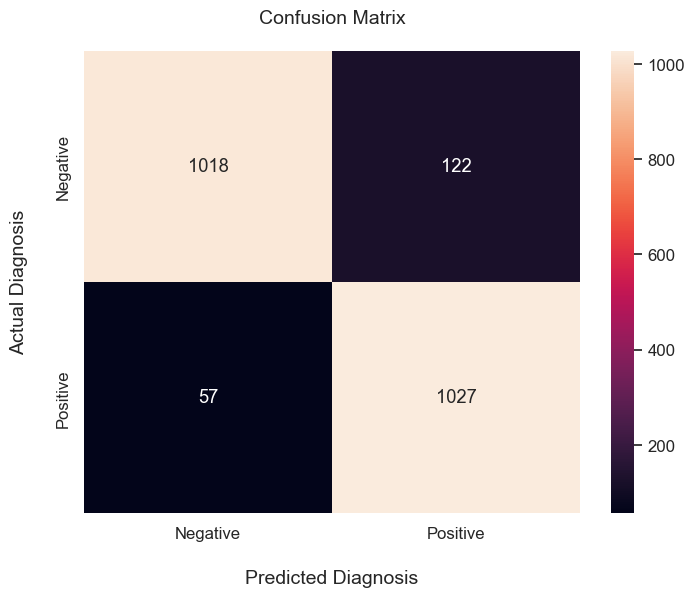

In [ ]:
predicted = best['clf'].predict(X_test_scaled if best['scaled'] else X_test)

print_metrics(y_test, predicted)
plot_conf_mat(y_test, predicted)